To produce word embeddings using Word2Vec, Gensim is often the library of choice. As a renowned Python library for natural language processing (NLP), Gensim offers comprehensive support for a range of word embedding models, such as Word2Vec, FastText, and Doc2Vec. The following guide provides a detailed walkthrough on leveraging Gensim to create word embeddings with the Word2Vec model, a widely adopted method in the field. To illustrate the algorithm, we present the code below, which is largely adapted from Jake Tae's study on Word2Vec: https://jaketae.github.io/study/word2vec/

## Preparing Data

In [5]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

## Tokenization

In [6]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

tokens = tokenize(text)
tokens

['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms',
 'that',
 'improve',
 'automatically',
 'through',
 'experience',
 'it',
 'is',
 'seen',
 'as',
 'a',
 'subset',
 'of',
 'artificial',
 'intelligence',
 'machine',
 'learning',
 'algorithms',
 'build',
 'a',
 'mathematical',
 'model',
 'based',
 'on',
 'sample',
 'data',
 'known',
 'as',
 'training',
 'data',
 'in',
 'order',
 'to',
 'make',
 'predictions',
 'or',
 'decisions',
 'without',
 'being',
 'explicitly',
 'programmed',
 'to',
 'do',
 'so',
 'machine',
 'learning',
 'algorithms',
 'are',
 'used',
 'in',
 'a',
 'wide',
 'variety',
 'of',
 'applications',
 'such',
 'as',
 'email',
 'filtering',
 'and',
 'computer',
 'vision',
 'where',
 'it',
 'is',
 'difficult',
 'or',
 'infeasible',
 'to',
 'develop',
 'conventional',
 'algorithms',
 'to',
 'perform',
 'the',
 'needed',
 'tasks']

## Creating look-up table

In [7]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

word_to_id, id_to_word = mapping(tokens)
word_to_id

{'known': 0,
 'through': 1,
 'in': 2,
 'on': 3,
 'are': 4,
 'filtering': 5,
 'to': 6,
 'email': 7,
 'decisions': 8,
 'used': 9,
 'automatically': 10,
 'learning': 11,
 'experience': 12,
 'artificial': 13,
 'make': 14,
 'predictions': 15,
 'improve': 16,
 'difficult': 17,
 'conventional': 18,
 'as': 19,
 'study': 20,
 'training': 21,
 'order': 22,
 'develop': 23,
 'subset': 24,
 'being': 25,
 'machine': 26,
 'model': 27,
 'where': 28,
 'it': 29,
 'intelligence': 30,
 'that': 31,
 'of': 32,
 'vision': 33,
 'sample': 34,
 'computer': 35,
 'programmed': 36,
 'without': 37,
 'do': 38,
 'variety': 39,
 'applications': 40,
 'and': 41,
 'infeasible': 42,
 'based': 43,
 'perform': 44,
 'the': 45,
 'so': 46,
 'mathematical': 47,
 'build': 48,
 'explicitly': 49,
 'data': 50,
 'a': 51,
 'wide': 52,
 'tasks': 53,
 'algorithms': 54,
 'or': 55,
 'is': 56,
 'such': 57,
 'needed': 58,
 'seen': 59}

## Generating Training Data

Now that we have tokenized the text and created lookup tables, we can now proceed to generating the actual training data, which are going to take the form of matrices. Since tokens are still in the form of strings, we need to encode them numerically using one-hot vectorization. We also need to generate a bundle of input and target values, as this is a supervised learning technique.

To generate training data, we loop through each word (or token) in the sentence. In each loop, we look at words to the left and right of the input word. For example in sentence 'Machine learning is the study of computer algorithms', the taret word now is 'study'. Then we would generate the following input and prediction pairs part of the training data. 

['study', 'is']
['study', 'the']
['study', 'of']
['study', 'computer']

Note that the window size is two, which is why we look up to two words to the left and right of the input word. So in a way, we can understand this as forcing the model to understand a rough sense of context—the ability to see which words tend to stick together. In our own example, for instance, we would see a lot of ["machine", "learning"], meaning that the model should be able to capture the close contextual affinity between these two words.

Below is the code that generates training data using the algorithm described above. We basically iterate over the tokenized data and generate pairs. One technicality here is that, for the first and last few tokens, it may not be possible to obtain words to the left or right of that input token. In those cases, we simply don’t consider these word pairs and look at only what is feasible without causing IndexErrors. Also note that we create X and y separately instead of putting them in tuple form as demonstrated above. This is just for convenience with other matrix operations later on in the post.

In [11]:
import numpy as np

np.random.seed(42)

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

def concat(*iterables):
    for iterable in iterables:
        yield from iterable
        
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

X, y = generate_training_data(tokens, word_to_id, 2)
X.shape,y.shape,X,y

((330, 60),
 (330, 60),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]]))

## The Embedding Model

In [13]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

model = init_network(len(word_to_id), 10)

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

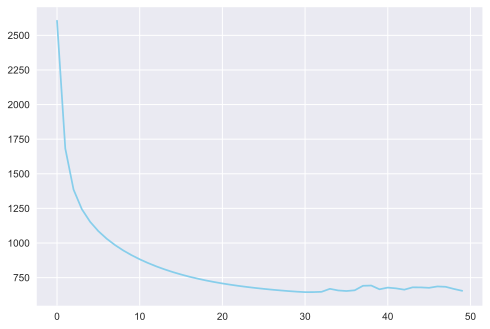

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

An obvious sanity check we can perform is to see which token our model predicts given the word “learning.” If the model was trained properly, the most likely word should understandably be “machine.” And indeed, when that is the result we get: notice that “machine” is at the top of the list of tokens, sorted by degree of affinity with “learning.”

In [15]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
algorithms
so
intelligence
build
the
is
are
learning
subset
artificial
or
conventional
without
do
explicitly
seen
a
that
used
develop
being
through
perform
where
decisions
data
study
applications
make
it
model
known
infeasible
wide
in
needed
mathematical
difficult
programmed
experience
tasks
based
automatically
predictions
variety
computer
to
such
vision
of
order
sample
as
on
training
email
improve
and
filtering


## Using Gensim

In [1]:
!pip install gensim

In [2]:
sentences = [
    ['this', 'is', 'the', 'first', 'sentence'],
    ['this', 'is', 'the', 'second', 'sentence'],
    ['this', 'is', 'the', 'third', 'sentence']
]

In [4]:
from gensim.models import Word2Vec

# Assuming 'sentences' is your list of tokenized sentences
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
vector = model.wv['first']
print(vector)
similar_words = model.wv.most_similar('first')
print(similar_words)

[ 8.1322715e-03 -4.4573355e-03 -1.0683584e-03  1.0063648e-03
 -1.9111396e-04  1.1481761e-03  6.1138608e-03 -2.0272731e-05
 -3.2459665e-03 -1.5107298e-03  5.8972980e-03  1.5141011e-03
 -7.2426320e-04  9.3332455e-03 -4.9212836e-03 -8.3841087e-04
  9.1754105e-03  6.7494274e-03  1.5028549e-03 -8.8825608e-03
  1.1487460e-03 -2.2882556e-03  9.3682362e-03  1.2099266e-03
  1.4900636e-03  2.4064088e-03 -1.8360066e-03 -4.9996353e-03
  2.3242951e-04 -2.0141816e-03  6.6009331e-03  8.9401221e-03
 -6.7475555e-04  2.9770136e-03 -6.1076544e-03  1.6993236e-03
 -6.9262339e-03 -8.6940266e-03 -5.9002042e-03 -8.9564752e-03
  7.2775935e-03 -5.7720328e-03  8.2763508e-03 -7.2435453e-03
  3.4216738e-03  9.6749971e-03 -7.7854488e-03 -9.9450592e-03
 -4.3291473e-03 -2.6831317e-03 -2.7128935e-04 -8.8315513e-03
 -8.6175585e-03  2.8002094e-03 -8.2064085e-03 -9.0693375e-03
 -2.3404669e-03 -8.6318087e-03 -7.0566512e-03 -8.4011508e-03
 -3.0133009e-04 -4.5642997e-03  6.6271736e-03  1.5271592e-03
 -3.3414769e-03  6.10897

## using existing trained word embedding

In [ ]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# If your model is Word2Vec
model = Word2Vec.load("path_to_your_model/word2vec.model")

#For models saved as KeyedVectors:
#model = KeyedVectors.load("path_to_your_model/wordvectors.kv")

# Get the vector for a word
word_vector = model.wv['example']  # Replace 'example' with your word

print(word_vector)